<a href="https://colab.research.google.com/github/zhou100/FoodSecurityPrediction/blob/master/PredictFS_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Use machine learning to predict food security

In [0]:
# Set up Notebook
% matplotlib inline

# Standard imports
from sklearn.model_selection import GridSearchCV

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from matplotlib import cm


# We do this to ignore several specific Pandas warnings
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score

 ## Read in the data cleaned out by R

If you are using google colab like me, you will need to mount your google drive first and  copy the cleaned dataset from the R project to your google drive. 

If you are using python/jupyter notebook locally, just point to the right directory. 

In [0]:
url = 'https://raw.githubusercontent.com/zhou100/FoodSecurityPrediction/master/data/mw_dataset_cluster.csv'
mw_clust = pd.read_csv(url)

## Preprocessing data


### Remove rows of missing values or extreme values

### One-hot encoding for string variables 

In [0]:
mw_clust["FNID"]= mw_clust["FNID"].str.lstrip('MW2012C')
fnid_mw_clust = pd.get_dummies(mw_clust["FNID"],prefix='MW', drop_first=True)
mw_clust = pd.concat([mw_clust, fnid_mw_clust], axis=1)


### Impute missing values and standarize variables 

In [0]:
from sklearn.preprocessing import StandardScaler

#ss = StandardScaler()

#mw_hh_X_train = ss.fit_transform(mw_hh_X_train)
#mw_hh_X_test = ss.fit_transform(mw_hh_X_test)
#tz_hh_X_train = ss.fit_transform(tz_hh_X_train)
#tz_hh_X_test = ss.fit_transform(tz_hh_X_test)
#ug_hh_X_train = ss.fit_transform(ug_hh_X_train)
#ug_hh_X_test = ss.fit_transform(ug_hh_X_test)

#mw_clust_X_train = ss.fit_transform(mw_clust_X_train)
#mw_clust_X_test = ss.fit_transform(mw_clust_X_test)
#tz_clust_X_train = ss.fit_transform(tz_clust_X_train)
#tz_clust_X_test = ss.fit_transform(tz_clust_X_test)
#ug_clust_X_train = ss.fit_transform(ug_clust_X_train)
#ug_clust_X_test = ss.fit_transform(ug_clust_X_test)



# Methodology


This section will explain our main approach with the data.

1. Focus on categorical prediciton for the given cutoffs. 
Reasons: More close to the actual policy scenarios. Can apply the down sampling and oversampling technique here.


2.  Algorithms to try : random forest with deep trees, xgboost 

2.4  Parameter Tuning

2.5 . feature importance analysis


3.  Error analysis by region, by group, by month

4.  Train model by division separtely Auto-segmentation by training a shallow tree based on observables 


5. Model combination: what happens when we train on all the data 

6. Model generalization issues: what happens when we directly apply  models trained on one country to predict another 

7. Distance to school and hospital 






## Exploratory Data Analysis  

### Measures:  plot target measures by year by country


In [5]:

mw_clust.head()

,ea_id,FS_year,FNID,Refrigerator,Radio,Television,Bicycle,Motorcycle,Car,number_celphones,floor_cement,floor_tile,floor_dirt_sand_dung,roof_natural,roof_iron,roof_other,cell_phone,hhsize,FS_month,dist_road,dist_popcenter,dist_admarc,ag_percent,elevation,rCSI,HDDS,FCS,dummy_terrain_rough,nutri_severe_constraint,nutri_moderate_constraint,asset_index,rural,clust_maize_price,clust_rice_price,clust_nuts_price,clust_beans_price,clust_maize_mktthin,clust_rice_mktthin,clust_nuts_mktthin,clust_beans_mktthin,...,MW_3020213,MW_3020303,MW_3020403,MW_3020503,MW_3020513,MW_3020515,MW_3020603,MW_3020619,MW_3020703,MW_3020803,MW_3020813,MW_3020815,MW_3020913,MW_3030112,MW_3030114,MW_3030115,MW_3030204,MW_3030206,MW_3030214,MW_3030304,MW_3030306,MW_3030314,MW_3030404,MW_3030414,MW_3030506,MW_3030514,MW_3030519,MW_3030606,MW_3030613,MW_3030714,MW_3030716,MW_3030804,MW_3030816,MW_3030904,MW_3031005,MW_3031105,MW_3031206,MW_3031213,MW_3031313,MW_3999918
0,10101016,2010,3010102,0.000000,0.437500,0.000000,0.375000,0.0,0.0,0.437500,0.062500,0.0,0.0,0.875000,0.125000,0.0,0.250000,5.937500,4.000000,2.656875,62.406875,12.016250,20.875000,1295.312500,3.625000,5.375000,39.968750,0,0.000000,0,-1.097918,1.000000,44.282500,247.276000,235.426000,187.412000,0.2,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,10101016,2013,3010102,0.000000,0.437500,0.000000,0.312500,0.0,0.0,0.250000,0.062500,0.0,0.0,0.937500,0.062500,0.0,0.250000,6.187500,4.000000,2.250000,62.562500,12.687500,23.250000,1296.250000,12.312500,4.687500,57.562500,0,0.000000,0,-1.272851,1.000000,117.495000,338.092614,260.726301,169.705691,0.5,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,10101204,2010,3010102,0.000000,0.437500,0.000000,0.500000,0.0,0.0,0.250000,0.125000,0.0,0.0,0.812500,0.187500,0.0,0.250000,5.437500,8.000000,0.513750,58.466875,10.821875,48.687500,1403.250000,2.687500,4.937500,32.093750,0,0.000000,0,-0.993365,1.000000,31.591000,176.821000,180.817000,167.261000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,10101204,2010,3010508,0.000000,0.437500,0.000000,0.500000,0.0,0.0,0.250000,0.125000,0.0,0.0,0.812500,0.187500,0.0,0.250000,5.437500,8.000000,0.513750,58.466875,10.821875,48.687500,1403.250000,2.687500,4.937500,32.093750,0,0.000000,0,-0.993365,1.000000,31.591000,176.821000,180.817000,167.261000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,10101204,2013,3010102,0.058824,0.352941,0.117647,0.352941,0.0,0.0,0.647059,0.176471,0.0,0.0,0.647059,0.352941,0.0,0.411765,5.529412,5.058824,0.529412,56.529412,11.411765,45.764706,1380.588235,4.470588,5.058824,68.264706,0,0.058824,0,-0.301647,0.941176,119.627402,400.969080,379.379586,347.946196,0.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


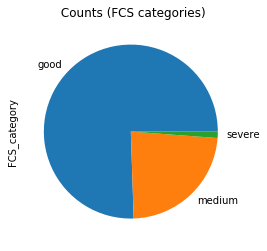

In [0]:
# cut the outcome variables by the cutoffs
mw_clust['FCS_category']= pd.cut(x=mw_clust['FCS'], bins=[0,28,42,100],labels= ["severe", "medium", "good"])
  
mw_clust['FCS_category'].value_counts().plot(kind='pie', title=' Counts (FCS categories)')


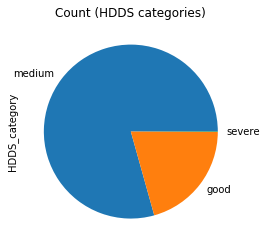

In [0]:
 # HDDS 3 and 6
mw_clust['HDDS_category']= pd.cut(x=mw_clust['HDDS'], bins=[0,3,6,10],labels= ["severe", "medium", "good"])
  
mw_clust['HDDS_category'].value_counts().plot(kind='pie', title='Count (HDDS categories)')


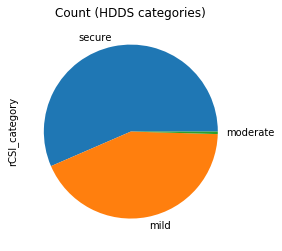

In [0]:
# rCSI 4 and 17  and 42
mw_clust['rCSI_category']= pd.cut(x=mw_clust['rCSI'], bins=[0,4,17,42],labels= ["secure", "mild", "moderate"])
  
mw_clust['rCSI_category'].value_counts().plot(kind='pie', title='Count (HDDS categories)')


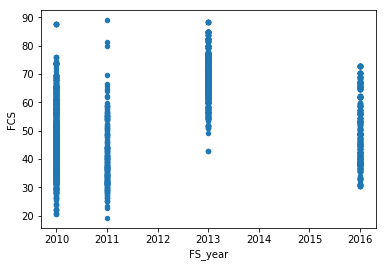

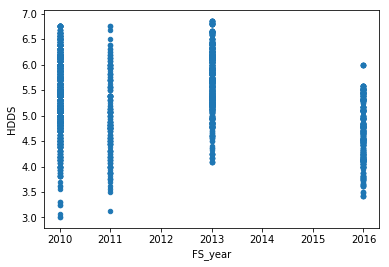

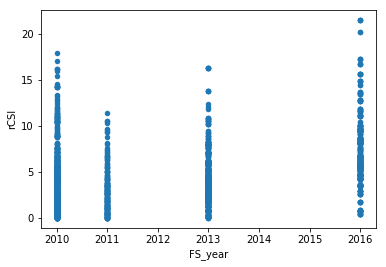

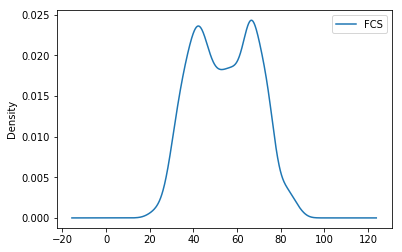

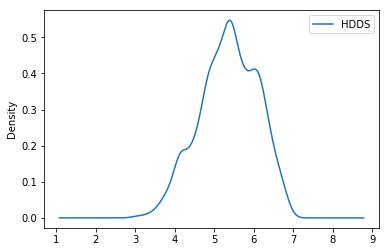

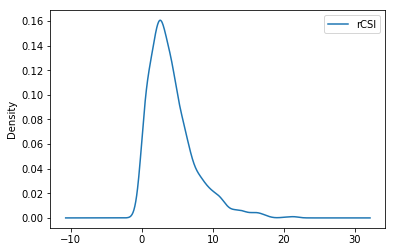

In [6]:
mw_clust.plot.scatter(x='FS_year', y='FCS')
mw_clust.plot.scatter(x='FS_year', y='HDDS')
mw_clust.plot.scatter(x='FS_year', y='rCSI')

mw_clust.plot.density(y='FCS')
mw_clust.plot.density(y='HDDS')
mw_clust.plot.density(y='rCSI')


### Asset related

### Weather

### Market Prices 

## Modelling


### Split train and test data

 For practical prediction purposes,  we use the most recent round of survey data  as the testing  and the rest as the training data. 


In [0]:
mw_clust_test_cond =  mw_clust['FS_year']>2015
mw_clust_train_cond =  mw_clust['FS_year']<2016
mw_clust_test = mw_clust[mw_clust_test_cond]
mw_clust_train = mw_clust[mw_clust_train_cond]



**Separate the target/labels from the X variables. **

In [0]:
labels = ['FCS', 'rCSI', 'HDDS']

 
mw_clust_y_train= mw_clust_train[labels]
mw_clust_y_test= mw_clust_test[labels]
 
mw_clust_X_test= mw_clust_test.drop(labels, axis=1)
mw_clust_X_train= mw_clust_train.drop(labels, axis=1)


In [0]:
from xgboost import XGBClassifier


### downsample / oversample 

Using simpler metrics like accuracy_score can be misleading. In a dataset with highly unbalanced classes, if the classifier always "predicts" the most common class without performing any analysis of the features, it will still have a high accuracy rate, obviously illusory.

Resampling
A widely adopted technique for dealing with highly unbalanced datasets is called resampling. It consists of removing samples from the majority class (under-sampling) and / or adding more examples from the minority class (over-sampling).

Despite the advantage of balancing classes, these techniques also have their weaknesses (there is no free lunch). The simplest implementation of over-sampling is to duplicate random records from the minority class, which can cause overfitting. In under-sampling, the simplest technique involves removing random records from the majority class, which can cause loss of information.



In [0]:
# Class count
count_class_0, count_class_1 = df_train.target.value_counts()

# Divide by class
df_class_0 = df_train[df_train['target'] == 0]
df_class_1 = df_train[df_train['target'] == 1]

df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under.target.value_counts())

df_test_under.target.value_counts().plot(kind='bar', title='Count (target)');


df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_test_over.target.value_counts())

df_test_over.target.value_counts().plot(kind='bar', title='Count (target)');


In [0]:
import imblearn


For example, we can cluster the records of the majority class, and do the under-sampling by removing records from each cluster, thus seeking to preserve information. In over-sampling, instead of creating exact copies of the minority class records, we can introduce small variations into those copies, creating more diverse synthetic samples.

Let's apply some of these resampling techniques, using the Python library imbalanced-learn. It is compatible with scikit-learn and is part of scikit-learn-contrib projects.

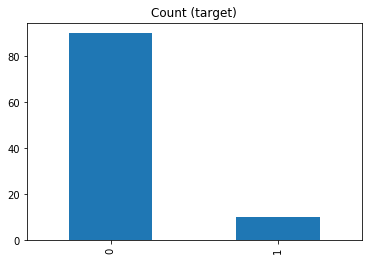

In [9]:
from sklearn.datasets import make_classification

X, y = make_classification(
    n_classes=2, class_sep=1.5, weights=[0.9, 0.1],
    n_informative=3, n_redundant=1, flip_y=0,
    n_features=20, n_clusters_per_class=1,
    n_samples=100, random_state=10
)

df = pd.DataFrame(X)
df['target'] = y
df.target.value_counts().plot(kind='bar', title='Count (target)');


In [0]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

In [0]:
y = mw_clust['rCSI_category'] 

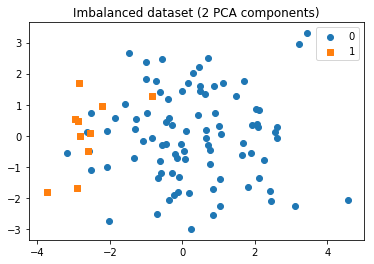

In [12]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X = pca.fit_transform(X)

plot_2d_space(X, y, 'Imbalanced dataset (2 PCA components)')

In [0]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(return_indices=True)
X_rus, y_rus, id_rus = rus.fit_sample(X, y)

print('Removed indexes:', id_rus)

plot_2d_space(X_rus, y_rus, 'Random under-sampling')

In [0]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_ros, y_ros = ros.fit_sample(X, y)

print(X_ros.shape[0] - X.shape[0], 'new random picked points')

plot_2d_space(X_ros, y_ros, 'Random over-sampling')

In [0]:
from imblearn.under_sampling import TomekLinks

tl = TomekLinks(return_indices=True, ratio='majority')
X_tl, y_tl, id_tl = tl.fit_sample(X, y)

print('Removed indexes:', id_tl)

plot_2d_space(X_tl, y_tl, 'Tomek links under-sampling')

In [0]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(ratio='minority')
X_sm, y_sm = smote.fit_sample(X, y)

plot_2d_space(X_sm, y_sm, 'SMOTE over-sampling')

In [0]:
from imblearn.combine import SMOTETomek

smt = SMOTETomek(ratio='auto')
X_smt, y_smt = smt.fit_sample(X, y)

plot_2d_space(X_smt, y_smt, 'SMOTE + Tomek links')

Under-sampling: Tomek links
Tomek links are pairs of very close instances, but of opposite classes. Removing the instances of the majority class of each pair increases the space between the two classes, facilitating the classification process.

In [0]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))


In [0]:
# confusion matrix , focus on improving the recall rate of the insecure class



In [0]:
# One vs all and plot the AUC ( )

### Models

In [8]:
# define a function that displays multiple results at the same time as a table
# input will be function and a character list
  
  def result_table(function,column_names=column_names):
    
    result_table = pd.DataFrame(columns=column_names)
    
    for index in range(len(X_train_list)):
      fcs_value = function(X_train_list[index],X_test_list[index],y_train_list[index]["FCS"],y_test_list[index]["FCS"])
      hdds_value = function(X_train_list[index],X_test_list[index],y_train_list[index]["HDDS"],y_test_list[index]["HDDS"])
      if index<4:
        rcsi_value = function(X_train_list[index],X_test_list[index],y_train_list[index]["rCSI"],y_test_list[index]["rCSI"])
      else:
        rcsi_value = 0
      
      fcs_value = '{0:.3f}'.format(fcs_value)
      hdds_value = '{0:.3f}'.format(hdds_value)
      rcsi_value = '{0:.3f}'.format(rcsi_value)
      
      
      temp_df = pd.DataFrame([[name_list[index], fcs_value, hdds_value, rcsi_value]], columns=column_names)
      
      result_table = result_table.append(temp_df, ignore_index=True)
      

  
    return result_table


  


NameError: ignored

#### Linear Regression

In [7]:
from sklearn.linear_model import LinearRegression

def fit_linear(X_train, X_test,y_train,y_test):

    # Create and fit our linear regression model to training data
    model = LinearRegression(fit_intercept=True)
    model.fit(X_train, y_train)

    # Compute model predictions for test data
    pred = model.predict(X_test)

    r2 = stats.pearsonr(y_test, pred)[0] ** 2
    
    return r2

# implement the algorithm and present results
result_table(function=fit_linear)

NameError: ignored

#### Ridge

In [0]:
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import RandomizedSearchCV


def fit_ridge(X_train, X_test,y_train,y_test):

  model = RidgeCV(alphas=[0.0, 1E-6, 1E-4, 1E-2, 1.0], fit_intercept=True, normalize=True, scoring=None, cv=5, gcv_mode='auto', store_cv_values=False) 

# Define different alpha values for different fits
# alpha = [0.0, 1E-6, 1E-4, 1E-2, 1.0]

  model.fit(X_train, y_train)

  # Compute model predictions for test data
  pred = model.predict(X_test)

  r2 = stats.pearsonr(y_test, pred)[0] ** 2
    
  return r2



# implement the algorithm and present results
result_table(function=fit_ridge)

,dataset,FCS,HDDS,rCSI
0,Malawi_household,0.265,0.270,0.110
1,Malawi_cluster,0.431,0.642,0.217
2,Tanzania_household,0.048,0.006,0.015
3,Tanzania_cluster,0.153,0.020,0.087
4,Uganda_household,0.179,0.219,0.000
5,Uganda_cluster,0.365,0.421,0.000


In [13]:
from sklearn.linear_model import LassoCV

def fit_lasso(X_train, X_test,y_train,y_test):

    model = LassoCV(eps=0.001, n_alphas=100, alphas=(0.01, 2), fit_intercept=True,precompute='auto',n_jobs=4, random_state=0, selection='cyclic')

    model.fit(X_train, y_train)
    
    pred = model.predict(X_test)

    r2= stats.pearsonr(y_test, pred)[0] ** 2
    return r2

  
# implement the algorithm and present results
result_table(function=fit_lasso)

NameError: ignored

In [0]:
from sklearn.linear_model import ElasticNetCV

def fit_en(X_train, X_test,y_train,y_test):


    model = ElasticNetCV(alphas=(0.1,0.02,3,2), copy_X=True, cv=10, eps=0.004, fit_intercept=True,
           l1_ratio=0.33, max_iter=1000, n_alphas=100, n_jobs=1,
           normalize=False, positive=False, precompute='auto', random_state=0,
           selection='cyclic', tol=0.0001, verbose=0)

    model.fit(X_train, y_train)
    
    pred = model.predict(X_test)

    r2= stats.pearsonr(y_test, pred)[0] ** 2
    
    return r2


# implement the algorithm and present results
result_table(function=fit_en)    
    

,dataset,FCS,HDDS,rCSI
0,Malawi_household,0.377,0.259,0.094
1,Malawi_cluster,0.683,0.587,0.192
2,Tanzania_household,0.048,0.005,0.015
3,Tanzania_cluster,0.153,0.020,0.088
4,Uganda_household,0.141,0.219,0.000
5,Uganda_cluster,0.264,0.387,0.000


In [0]:
from sklearn.ensemble import RandomForestRegressor

def fit_rfc(X_train, X_test,y_train,y_test):
  # Create Regressor with default properties
  rfc = RandomForestRegressor(random_state =0,n_jobs =4,warm_start = True,max_depth=4, min_samples_leaf=5 )
  
  
  parameters = {'max_depth':np.arange( 1,4, 1 ).tolist(), 'min_samples_leaf':np.arange( 1, 4, 1 ).tolist()}
  model = GridSearchCV(rfc, parameters,cv=6, n_jobs= 4, iid = True,  refit= True,pre_dispatch= '2*n_jobs')

  model.fit(X_train,y_train)
  # Fit estimator and display score

  # Regress on test data
  pred = model.predict(X_test)

  r2 = stats.pearsonr(y_test, pred)[0] ** 2
    
  return r2

result_table(function=fit_rfc)

,dataset,FCS,HDDS,rCSI
0,Malawi_household,0.369,0.269,0.115
1,Malawi_cluster,0.713,0.706,0.267
2,Tanzania_household,0.195,0.221,0.048
3,Tanzania_cluster,0.289,0.385,0.127
4,Uganda_household,0.172,0.189,0.000
5,Uganda_cluster,0.314,0.435,0.000


In [0]:
from sklearn.ensemble import GradientBoostingRegressor

# Create Regressor with default properties
gbr = GradientBoostingRegressor(random_state=0,learning_rate=0.4, n_estimators=9,subsample=1, criterion='friedman_mse', min_samples_split=2)

gbr.fit(x_train, y_train_new)
pred = gbr.predict(x_test)

actual =y_test_new
r2_gbr= stats.pearsonr(actual, pred)[0] ** 2
r2_gbr

In [0]:
from sklearn.gaussian_process import  GaussianProcessRegressor

# Import our kernels
from sklearn.gaussian_process.kernels import Matern, WhiteKernel



# Define custom kernel (Matern + noise)
krnl = 2. + Matern(length_scale=1, nu=1.8) + WhiteKernel(noise_level=10)

# Create Regressor with specified properties
gpr = GaussianProcessRegressor(kernel=krnl, random_state=23)

# Fit estimator and display score
gpr= gpr.fit(x_train, y_train[labels[0]])
pred = gpr.predict(x_test)
actual = y_test[labels[0]]
r2_gpr= stats.pearsonr(actual, pred)[0] ** 2
r2_gpr

pd = {'svc__C': st.uniform(0, 250),
      'svc__gamma': g_vals}
 
# Run randomized search
rscv = RandomizedSearchCV(svp, param_distributions=pd,
                          n_iter=num_samples)

## Visualization

In [0]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].scatter( actual_linear,pred_linear)
axs[0, 0].plot(actual_linear,actual_linear, color='red')

axs[1, 0].scatter( actual_rfr, pred_rfr)
axs[1, 0].plot(actual_rfr, actual_rfr, color='red')


axs[0, 1].scatter(actual_en ,pred_en )
axs[0, 1].plot(actual_en,actual_en, color='red')

axs[1, 1].scatter(actual_gbr, pred_gbr )
axs[1, 1].plot(actual_gbr, actual_gbr, color='red')


axs[0, 0].title.set_text('Scatter Plot Linear')
axs[1, 0].title.set_text('Scatter Plot RandomForest')
axs[0, 1].title.set_text('Scatter Plot ElasticNet')
axs[1, 1].title.set_text('Scatter Plot GradientBoosting')
plt.show()

## Interpretation


Hit and misses 

expand the prediction to grid level 